In [2]:
%load_ext autoreload 
%autoreload 2
import sys
from os import path
import glob
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
sys.path.append("..")


In [3]:
path_to_test="../test_report"

# Testing Pretrained Models

## Output from test procedure

First we will aggregate the results csv obtained on each pretrained model when running `cli.py test pretrain`

In [8]:
full_results = []
mrart_results=[]
for models_directory in glob.glob(path.join(path_to_test,"pretraining", "*")):
    model, task, *_ = path.basename(models_directory).split("-")

    results = pd.read_csv(path.join(models_directory, "results.csv"))
    results['model']=model
    results['task']=task
    full_results.append(results[['model', 'task','source','r2','rmse']])

    mrart = pd.read_csv(path.join(models_directory, 'mrart_recap.csv'))
    mrart['model']=model
    mrart['task']=task
    mrart_results.append(mrart[['model', 'task', 'balanced_accuracy','threshold_1','threshold_2','accuracy_0','accuracy_1','accuracy_2']])

full_results =pd.concat(full_results)
mrart_results =pd.concat(mrart_results)

motion_res = full_results[full_results['task']=="MOTION"]
ssim_res = full_results[full_results['task']=="SSIM"]

,model,task,balanced_accuracy,threshold_1,threshold_2,accuracy_0,accuracy_1,accuracy_2
0,VIT,MOTION,0.559513,0.065194,0.083433,0.523077,0.325581,0.714286
0,SERES,MOTION,0.585065,0.869055,1.670797,0.509091,0.325581,0.850000
0,CONV5_FC3,MOTION,0.612208,0.867532,1.266774,0.476190,0.500000,0.868421
0,RES,MOTION,0.596722,0.583335,1.077534,0.421053,0.491803,0.886076


### Analysis of motion results

Text(0.5, 1.0, 'Root mean squared error test results')

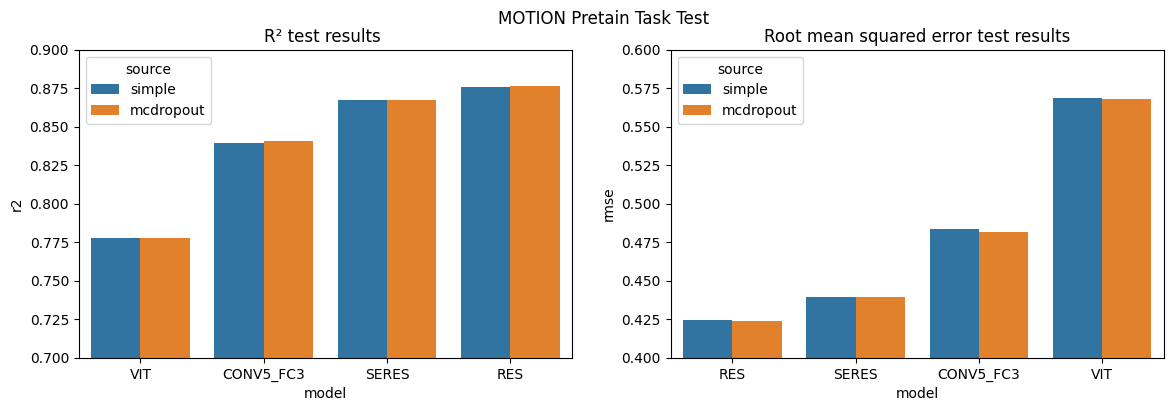

In [35]:
fig=plt.figure(figsize=(14,4))
fig.suptitle("MOTION Pretain Task Test")

plt.subplot(1,2,1)
sb.barplot(motion_res.sort_values("r2"), x="model", hue="source", y="r2", hue_order=('simple', 'mcdropout'))
plt.ylim((0.7,0.9))
plt.title("R² test results ")


plt.subplot(1,2,2)
sb.barplot(motion_res.sort_values("rmse"), x="model", hue="source", y="rmse", hue_order=('simple', 'mcdropout'))
plt.ylim((0.4,0.6))
plt.title("Root mean squared error test results")


### Analysis of SSIM results

Text(0.5, 1.0, 'Root mean squared error results')

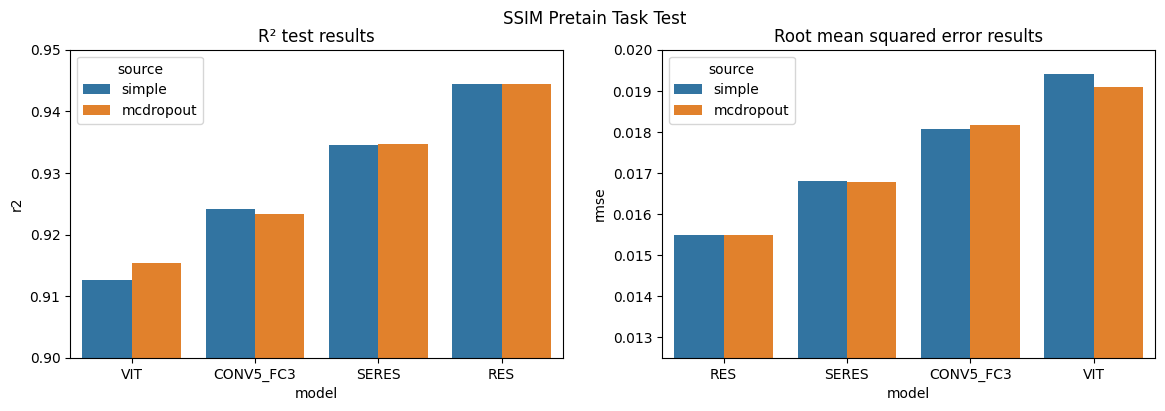

In [34]:
fig = plt.figure(figsize=(14,4))
fig.suptitle("SSIM Pretain Task Test")
plt.subplot(1,2,1)
sb.barplot(ssim_res.sort_values("r2"), x="model", hue="source", y="r2", hue_order=('simple', 'mcdropout'))
plt.ylim((0.9,0.95))
plt.title("R² test results")


plt.subplot(1,2,2)
sb.barplot(ssim_res.sort_values("rmse"), x="model", hue="source", y="rmse", hue_order=('simple', 'mcdropout'))
plt.ylim((0.0125,0.02))
plt.title("Root mean squared error results")

### Analysis of MR-ART predictions

In [28]:
task_hue_order=('SSIM', 'MOTION')

Now let's test how it perform on the MR-ART dataset, we trained a two threshold classifier on our pretrained network output to assess correlation of the network output and MR-ART classes with simple threshold based decision

Text(0.5, 1.0, 'Average Balanced Accuracy By Task for Threshold Models')

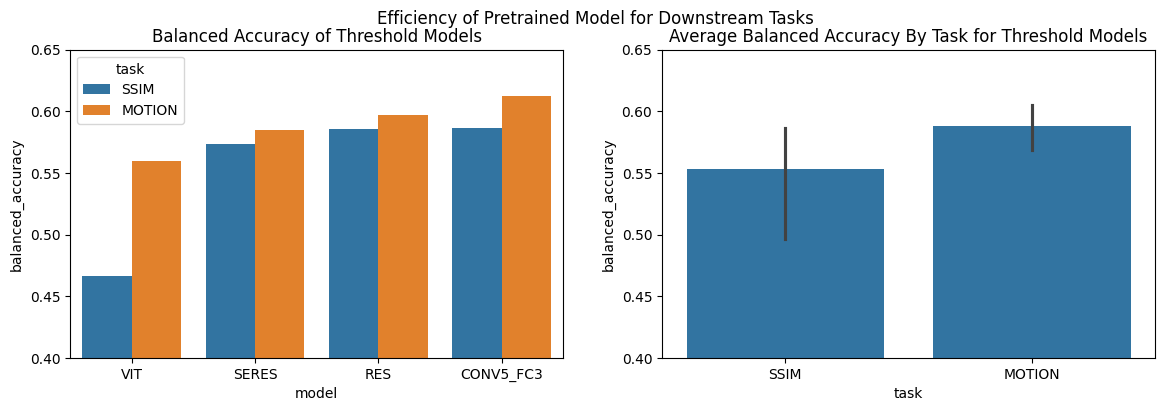

In [33]:
fig = plt.figure(figsize=(14,4))
fig.suptitle("Efficiency of Pretrained Model for Downstream Tasks")
plt.subplot(1,2,1)
sb.barplot(mrart_results.sort_values("balanced_accuracy"), x="model", y="balanced_accuracy", hue="task", hue_order=task_hue_order)
plt.ylim((0.4,0.65))
plt.title("Balanced Accuracy of Threshold Models")

plt.subplot(1,2,2)
sb.barplot(mrart_results.sort_values("balanced_accuracy"), x="task",  y="balanced_accuracy")
plt.ylim((0.4,0.65))
plt.title("Average Balanced Accuracy By Task for Threshold Models")

Let's delve a bit into each classes f1 score for each scenario :

Text(0.5, 1.0, 'Class 2')

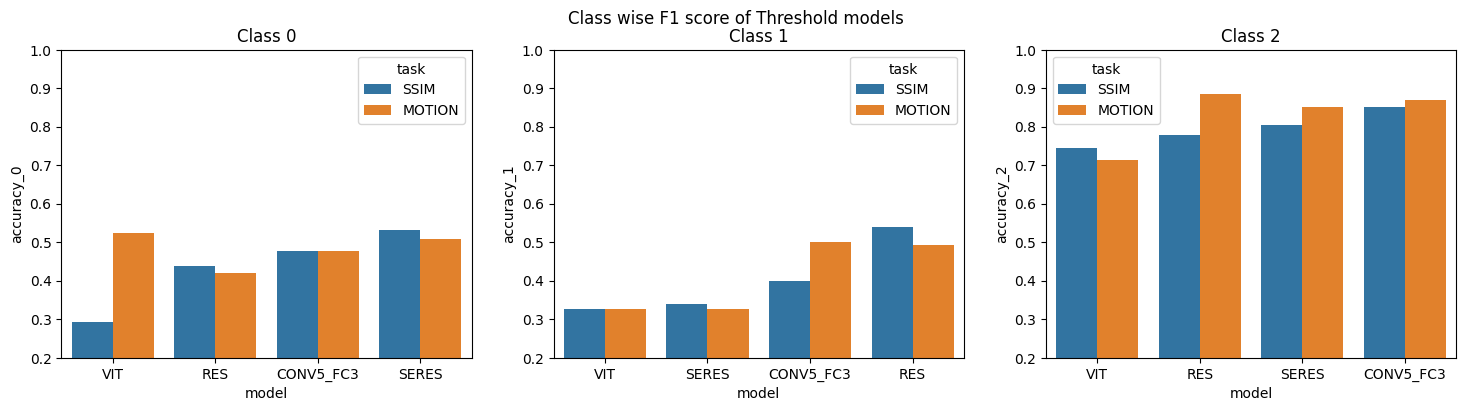

In [39]:
fig=plt.figure(figsize=(18,4))
fig.suptitle("Class wise F1 score of Threshold models")
plt.subplot(1,3,1)
sb.barplot(mrart_results.sort_values("accuracy_0"), x="model", y="accuracy_0",hue="task", hue_order=task_hue_order)
plt.ylim((0.2,1))
plt.title("Class 0")

plt.subplot(1,3,2)
sb.barplot(mrart_results.sort_values("accuracy_1"), x="model",  y="accuracy_1",hue="task", hue_order=task_hue_order)
plt.ylim((0.2,1))
plt.title("Class 1")

plt.subplot(1,3,3)
sb.barplot(mrart_results.sort_values("accuracy_2"), x="model",  y="accuracy_2",hue="task", hue_order=task_hue_order)
plt.ylim((0.2,1))
plt.title("Class 2")

## Training From Scratch

In [34]:
full_results = []
for models_directory in glob.glob(path.join(path_to_test,"scratch", "*")):
    model, *_ = path.basename(models_directory).split("-")

    results = pd.read_csv(path.join(models_directory, "mrart_recap.csv"))
    results['model']=model
    full_results.append(results[['model', 'mode','balanced_accuracy','f1_0','f1_1','f1_2']])

full_results =pd.concat(full_results)
averaged_res = full_results.groupby(["model","mode"], as_index=False).agg(['mean', 'std'])
averaged_res.columns = ['_'.join(col).strip().strip("_") for col in averaged_res.columns.values]
averaged_res

,model,mode,balanced_accuracy_mean,balanced_accuracy_std,f1_0_mean,f1_0_std,f1_1_mean,f1_1_std,f1_2_mean,f1_2_std
0,CONV5_FC3,mcdropout,0.504194,0.057968,0.634223,0.053656,0.381683,0.016929,0.318370,0.131547
1,CONV5_FC3,simple,0.606022,0.030714,0.586269,0.089954,0.327041,0.188469,0.817546,0.022473
2,RES,mcdropout,0.562834,0.076081,0.670573,0.054018,0.371473,0.044024,0.458753,0.220612
3,RES,simple,0.682763,0.069766,0.708148,0.054506,0.249945,0.282377,0.862056,0.030524
4,SERES,mcdropout,0.693905,0.034689,0.735053,0.015815,0.470459,0.053968,0.756090,0.048088
5,SERES,simple,0.740061,0.048377,0.784569,0.053050,0.513151,0.053879,0.870768,0.028237
6,SFCN,mcdropout,0.473893,0.038944,0.699547,0.039563,0.270288,0.058367,0.080275,0.094738
7,SFCN,simple,0.736362,0.072532,0.704143,0.167727,0.557038,0.093300,0.885270,0.032554
8,VIT,mcdropout,0.757724,0.030305,0.736604,0.025317,0.613853,0.068180,0.895951,0.031524
9,VIT,simple,0.749267,0.026783,0.746887,0.047087,0.572854,0.050373,0.907840,0.009587


Text(0.5, 1.0, 'Accuracy test results')

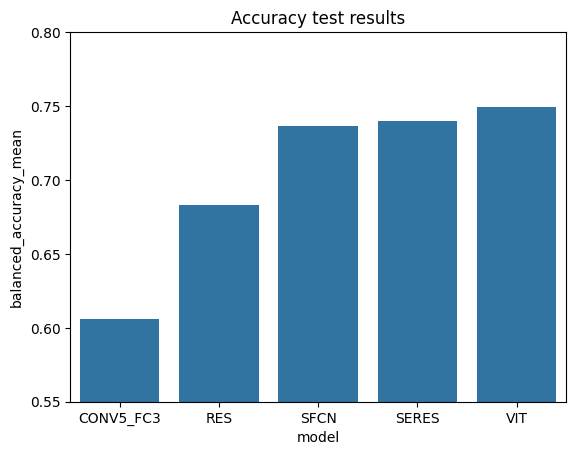

In [37]:
sb.barplot(averaged_res[averaged_res['mode']=='simple'].sort_values("balanced_accuracy_mean"), x="model", y="balanced_accuracy_mean")
plt.ylim((0.55,0.8))
plt.title("Accuracy test results")

Text(0.5, 1.0, 'Accuracy test results')

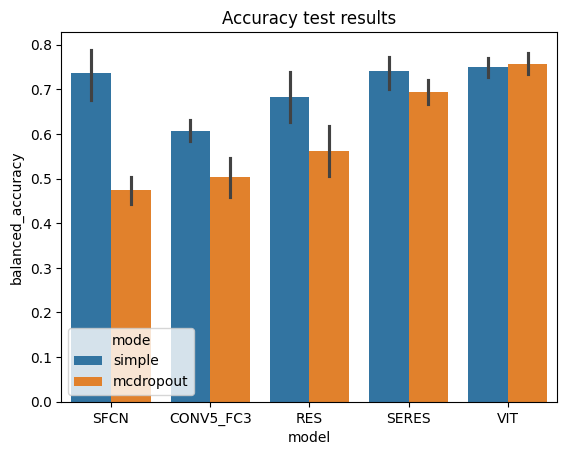

In [40]:
sb.barplot(full_results.sort_values("balanced_accuracy"), x="model", hue="mode", y="balanced_accuracy", hue_order=('simple', 'mcdropout'))
# plt.ylim((0.4,0.8))
plt.title("Accuracy test results")

Text(0.5, 1.0, 'Accuracy Variance test results')

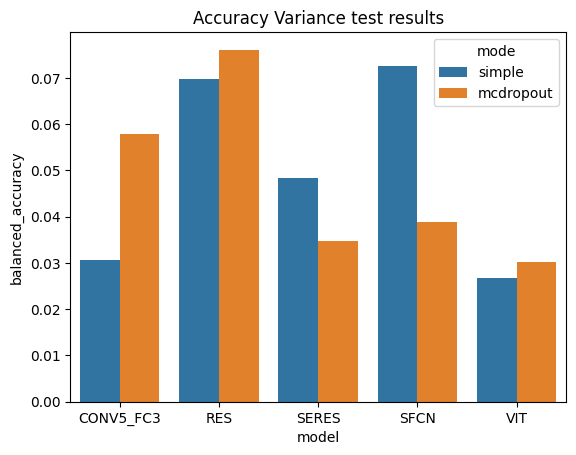

In [38]:
sb.barplot(full_results.groupby(["model","mode"]).std(), x="model", hue="mode", y="balanced_accuracy", hue_order=('simple', 'mcdropout'))
# plt.ylim((0.9,0.95))
plt.title("Accuracy Variance test results")